# Example Usage of Battery Optimisation Model

## Setup

In [1]:
from pathlib import Path

from chronos.lite.data import load_battery_config, load_market_data
from chronos.lite.model import Model

DATA_DIR = Path.cwd() / "data"

## Load in data

In [2]:
battery_config = load_battery_config(DATA_DIR / "battery_parameters.csv")
battery_config

{'Max charging rate': 2.0,
 'Max discharging rate': 2.0,
 'Max storage volume': 4.0,
 'Battery charging loss': 0.05,
 'Battery discharging loss': 0.05,
 'Lifetime (1)': 10.0,
 'Lifetime (2)': 5000.0,
 'Storage volume degradation rate': 0.001,
 'Capex': 500000.0,
 'Fixed Operational Costs': 5000.0}

In [3]:
market_data = load_market_data(
    half_hourly_csv=DATA_DIR / "half-hourly-market.csv",
    hourly_csv=DATA_DIR / "hourly-market.csv",
    nrows=500,  # Limit datasize due to memory issues
)
market_data.head()

,Price 30 min (£/MWh),Price 60 min (£/MWh)
time,,
2018-01-01 00:00:00,48.47,51.89
2018-01-01 00:30:00,49.81,51.89
2018-01-01 01:00:00,53.65,55.49
2018-01-01 01:30:00,52.48,55.49
2018-01-01 02:00:00,47.25,51.06


## Instantiate the model

The battery optimisation model subclasses `linopy.Model`, adding variables and constraints on instantiation.

In [4]:
model = Model(battery_config, market_data)

View the model variables:

In [5]:
model.variables

linopy.model.Variables
----------------------
 * is charging (time)
 * is discharging (time)
 * charge rate 30 (time)
 * discharge rate 30 (time)
 * charge rate 60 (time)
 * discharge rate 60 (time)

Inspect a given model variable:

In [6]:
model.variables["charge rate 60"]

Variable (time: 50)
-------------------
[2018-01-01 00:00:00]: charge rate 60[2018-01-01 00:00:00] ∈ [0, 2]
[2018-01-01 00:30:00]: charge rate 60[2018-01-01 00:30:00] ∈ [0, 2]
[2018-01-01 01:00:00]: charge rate 60[2018-01-01 01:00:00] ∈ [0, 2]
[2018-01-01 01:30:00]: charge rate 60[2018-01-01 01:30:00] ∈ [0, 2]
[2018-01-01 02:00:00]: charge rate 60[2018-01-01 02:00:00] ∈ [0, 2]
[2018-01-01 02:30:00]: charge rate 60[2018-01-01 02:30:00] ∈ [0, 2]
[2018-01-01 03:00:00]: charge rate 60[2018-01-01 03:00:00] ∈ [0, 2]
		...
[2018-01-01 21:30:00]: charge rate 60[2018-01-01 21:30:00] ∈ [0, 2]
[2018-01-01 22:00:00]: charge rate 60[2018-01-01 22:00:00] ∈ [0, 2]
[2018-01-01 22:30:00]: charge rate 60[2018-01-01 22:30:00] ∈ [0, 2]
[2018-01-01 23:00:00]: charge rate 60[2018-01-01 23:00:00] ∈ [0, 2]
[2018-01-01 23:30:00]: charge rate 60[2018-01-01 23:30:00] ∈ [0, 2]
[2018-01-02 00:00:00]: charge rate 60[2018-01-02 00:00:00] ∈ [0, 2]
[2018-01-02 00:30:00]: charge rate 60[2018-01-02 00:30:00] ∈ [0, 2]

View the model constraints:

In [7]:
model.constraints

linopy.model.Constraints
------------------------
 * charge/discharge exclusive (time)
 * max charge rate (time)
 * max discharge rate (time)
 * available stored energy (time)
 * available storage capacity (time)
 * 60 min charge full hour (time)
 * 60 min discharge full hour (time)

Inspect a given model constraint:

In [8]:
model.constraints["max discharge rate"]

Constraint `max discharge rate` [time: 50]:
-------------------------------------------
[2018-01-01 00:00:00]: +1 discharge rate 30[2018-01-01 00:00:00] + 1 discharge rate 60[2018-01-01 00:00:00] - 2 is discharging[2018-01-01 00:00:00] ≤ -0.0
[2018-01-01 00:30:00]: +1 discharge rate 30[2018-01-01 00:30:00] + 1 discharge rate 60[2018-01-01 00:30:00] - 2 is discharging[2018-01-01 00:30:00] ≤ -0.0
[2018-01-01 01:00:00]: +1 discharge rate 30[2018-01-01 01:00:00] + 1 discharge rate 60[2018-01-01 01:00:00] - 2 is discharging[2018-01-01 01:00:00] ≤ -0.0
[2018-01-01 01:30:00]: +1 discharge rate 30[2018-01-01 01:30:00] + 1 discharge rate 60[2018-01-01 01:30:00] - 2 is discharging[2018-01-01 01:30:00] ≤ -0.0
[2018-01-01 02:00:00]: +1 discharge rate 30[2018-01-01 02:00:00] + 1 discharge rate 60[2018-01-01 02:00:00] - 2 is discharging[2018-01-01 02:00:00] ≤ -0.0
[2018-01-01 02:30:00]: +1 discharge rate 30[2018-01-01 02:30:00] + 1 discharge rate 60[2018-01-01 02:30:00] - 2 is discharging[2018-01-01

NB: for implementing the constraints, the model also calculates stored energy as a linear expression:

In [9]:
model.stored_energy

LinearExpression [time: 50]:
----------------------------
[2018-01-01 00:00:00]: +0
[2018-01-01 00:30:00]: +0.475 charge rate 30[2018-01-01 00:00:00] + 0.475 charge rate 60[2018-01-01 00:00:00] - 0.5 discharge rate 30[2018-01-01 00:00:00] - 0.5 discharge rate 60[2018-01-01 00:00:00]
[2018-01-01 01:00:00]: +0.475 charge rate 30[2018-01-01 00:00:00] + 0.475 charge rate 30[2018-01-01 00:30:00] + 0.475 charge rate 60[2018-01-01 00:00:00] ... -0.5 discharge rate 30[2018-01-01 00:30:00] - 0.5 discharge rate 60[2018-01-01 00:00:00] - 0.5 discharge rate 60[2018-01-01 00:30:00]
[2018-01-01 01:30:00]: +0.475 charge rate 30[2018-01-01 00:00:00] + 0.475 charge rate 30[2018-01-01 00:30:00] + 0.475 charge rate 30[2018-01-01 01:00:00] ... -0.5 discharge rate 60[2018-01-01 00:00:00] - 0.5 discharge rate 60[2018-01-01 00:30:00] - 0.5 discharge rate 60[2018-01-01 01:00:00]
[2018-01-01 02:00:00]: +0.475 charge rate 30[2018-01-01 00:00:00] + 0.475 charge rate 30[2018-01-01 00:30:00] + 0.475 charge rate 30

## Solve the model

We'll use the HiGHS solver, which is easy to install via the `highspy` package.

In [10]:
model.solve(solver_name="highs")

('ok', 'optimal')

Show the model solution:

In [11]:
model.solution

<xarray.Dataset> Size: 3kB
Dimensions:            (time: 50)
Coordinates:
  * time               (time) datetime64[ns] 400B 2018-01-01 ... 2018-01-02T0...
Data variables:
    is charging        (time) float64 400B 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 0.0
    is discharging     (time) float64 400B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0
    charge rate 30     (time) float64 400B 0.0 0.0 0.0 0.0 ... 0.0 -0.0 0.0 0.0
    discharge rate 30  (time) float64 400B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    charge rate 60     (time) float64 400B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    discharge rate 60  (time) float64 400B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

Plot the battery optimisation model solution using the built-in visualisation:

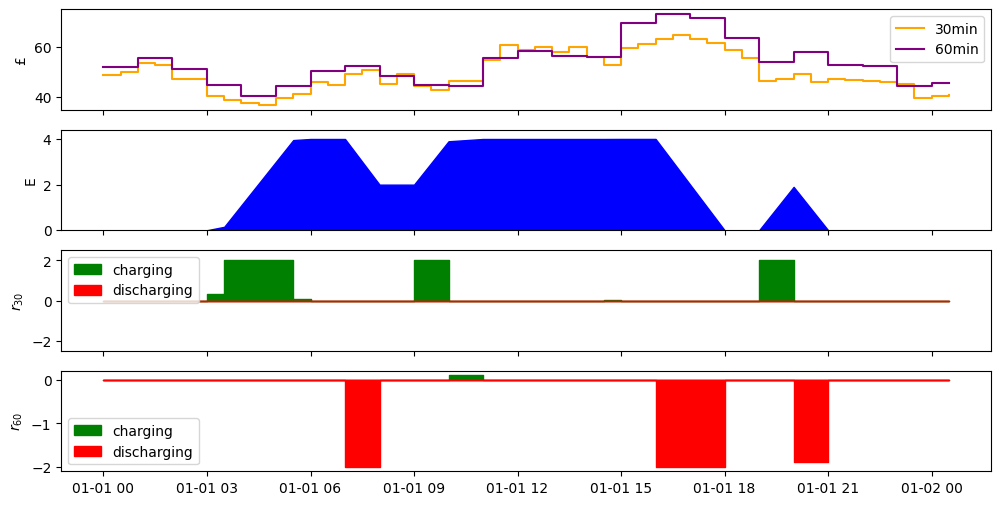

In [12]:
model.plot_solution()

Inspect solution values like:

In [13]:
model.variables["charge rate 30"].solution[:25]

<xarray.DataArray 'solution' (time: 25)> Size: 200B
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.31578947, 2.        , 2.        , 2.        ,
       2.        , 0.1       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 2.        , 2.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])
Coordinates:
  * time     (time) datetime64[ns] 200B 2018-01-01 ... 2018-01-01T12:00:00

In [14]:
model.stored_energy.solution[:25]

<xarray.DataArray 'solution' (time: 25)> Size: 200B
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.15      , 1.1       , 2.05      ,
       3.        , 3.95      , 3.9975    , 3.9975    , 3.9975    ,
       2.9975    , 1.9975    , 1.9975    , 1.9975    , 2.9475    ,
       3.8975    , 3.9474359 , 3.99737179, 3.99737179, 3.99737179])
Coordinates:
  * time     (time) datetime64[ns] 200B 2018-01-01 ... 2018-01-01T12:00:00

## Output model results

In [15]:
model.solution_to_dataframe()

,is charging,is discharging,charge rate 30,discharge rate 30,charge rate 60,discharge rate 60,stored energy
time,,,,,,,
2018-01-01 00:00:00,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00
2018-01-01 00:30:00,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00
2018-01-01 01:00:00,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00
2018-01-01 01:30:00,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00
2018-01-01 02:00:00,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00
2018-01-01 02:30:00,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00
2018-01-01 03:00:00,1.0,0.0,0.315789,0.0,0.000000,0.0,0.000000e+00
2018-01-01 03:30:00,1.0,0.0,2.000000,0.0,0.000000,0.0,1.500000e-01
2018-01-01 04:00:00,1.0,0.0,2.000000,0.0,-0.000000,0.0,1.100000e+00
